In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Ruta a los archivos
clientes_path = "data/small-vrp/vrp.csv"
vehiculos_path = "data/small-vrp/2.vehicles.csv"

# Leer datos de clientes
df_clientes = pd.read_csv(clientes_path, sep=";")
df_clientes.head()

,ID,X,Y,Demand
0,0,25.660036,-9.793401,0
1,1,80.011644,-55.493543,12
2,2,13.439953,-63.729201,7
3,3,21.501643,22.994351,3
4,4,-84.928462,27.941901,18


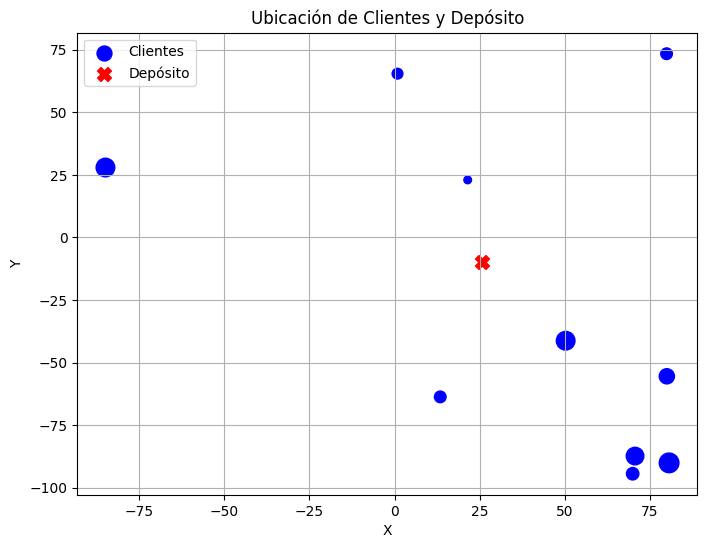

In [4]:
# Identificar depósito
deposito = df_clientes[df_clientes["ID"] == 0].iloc[0]
clientes = df_clientes[df_clientes["ID"] != 0]

# Graficar
plt.figure(figsize=(8,6))
plt.scatter(clientes["X"], clientes["Y"], c='blue', label="Clientes", s=clientes["Demand"]*10)
plt.scatter(deposito["X"], deposito["Y"], c='red', label="Depósito", marker="X", s=100)
plt.title("Ubicación de Clientes y Depósito")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# Leer archivo de clientes y depósito
clientes_path = "./data/vrp.csv"
df_clientes = pd.read_csv(clientes_path, sep=";")

# Asignar nombres como 'A', 'B', 'C', ... para compatibilidad con test.py
letras = [chr(i) for i in range(65, 65 + len(df_clientes))]
df_clientes["Nombre"] = letras

# Mostrar una muestra
df_clientes.head()

,ID,X,Y,Demand,Nombre
0,0,3.532325,-5.301723,0,A
1,1,80.011644,-55.493543,12,B
2,2,13.439953,-63.729201,7,C
3,3,21.501643,22.994351,3,D
4,4,-84.928462,27.941901,18,E


In [7]:
from util import generar_distancias

# Crear diccionario de ciudades con coordenadas
ciudades = {
    row["Nombre"]: (row["X"], row["Y"])
    for _, row in df_clientes.iterrows()
}

# Crear diccionario de distancias
distancias = generar_distancias(ciudades)

# Verificar que se haya generado correctamente
print(f"{len(ciudades)} ciudades y {len(distancias)} distancias generadas.")

100 ciudades y 9900 distancias generadas.


In [10]:
from test_vrp_ar import VRP

# Crear instancia del modelo
modelo_vrp = VRP(ciudades=ciudades, distancias=distancias, heuristics=[])

# Mostrar distancias mínimas y máximas de referencia
modelo_vrp.print_min_max_distances()

Distancia mínima entre nodos: 1.7891308257406089
Distancia máxima entre nodos: 254.81696825413124
Distancia promedio entre nodos: 101.21699570218209
Distancia Total mínima posible: 1287.5765815990337
Distancia Total máxima posible: 3090.183795837681
Heurísticas aplicadas: []


In [11]:
vehiculos_path = "./data/small-vrp/2.vehicles.csv"
df_vehiculos = pd.read_csv(vehiculos_path, sep=";")
df_vehiculos

,Vehicle_ID,Capacity
0,1,60
1,2,60


In [12]:
# Obtener solo clientes (excluyendo el depósito)
clientes = df_clientes[df_clientes["ID"] != 0].copy()

# Calcular demanda total
demanda_total = clientes["Demand"].sum()
print("Demanda total de clientes:", demanda_total)

# Capacidad total disponible
capacidad_total = df_vehiculos["Capacity"].sum()
print("Capacidad total de flota:", capacidad_total)

Demanda total de clientes: 1168
Capacidad total de flota: 120


In [13]:
vehiculo_capacidades = df_vehiculos["Capacity"].tolist()
grupos_clientes = [[] for _ in range(len(vehiculo_capacidades))]
grupos_demanda = [0 for _ in range(len(vehiculo_capacidades))]

# Ordenar clientes por demanda descendente (puedes cambiar a proximidad si deseas)
clientes_sorted = clientes.sort_values(by="Demand", ascending=False)

for _, cliente in clientes_sorted.iterrows():
    for i in range(len(vehiculo_capacidades)):
        if grupos_demanda[i] + cliente["Demand"] <= vehiculo_capacidades[i]:
            grupos_clientes[i].append(cliente["Nombre"])
            grupos_demanda[i] += cliente["Demand"]
            break

In [14]:
from util_nearest_neighbor import nearest_neighbor

# Agregar el depósito (normalmente es 'A') al inicio de cada grupo
deposito = df_clientes[df_clientes["ID"] == 0]["Nombre"].values[0]

rutas = []
for grupo in grupos_clientes:
    ruta = [deposito] + grupo + [deposito]  # ida y vuelta
    sub_ciudades = {nombre: ciudades[nombre] for nombre in ruta}
    sub_distancias = {k: v for k, v in distancias.items() if k[0] in ruta and k[1] in ruta}
    
    ruta_ordenada = nearest_neighbor(sub_ciudades, sub_distancias)
    rutas.append(ruta_ordenada)

C:\Users\aramirez\AppData\Local\Temp\ipykernel_29244\2858794217.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(rutas))


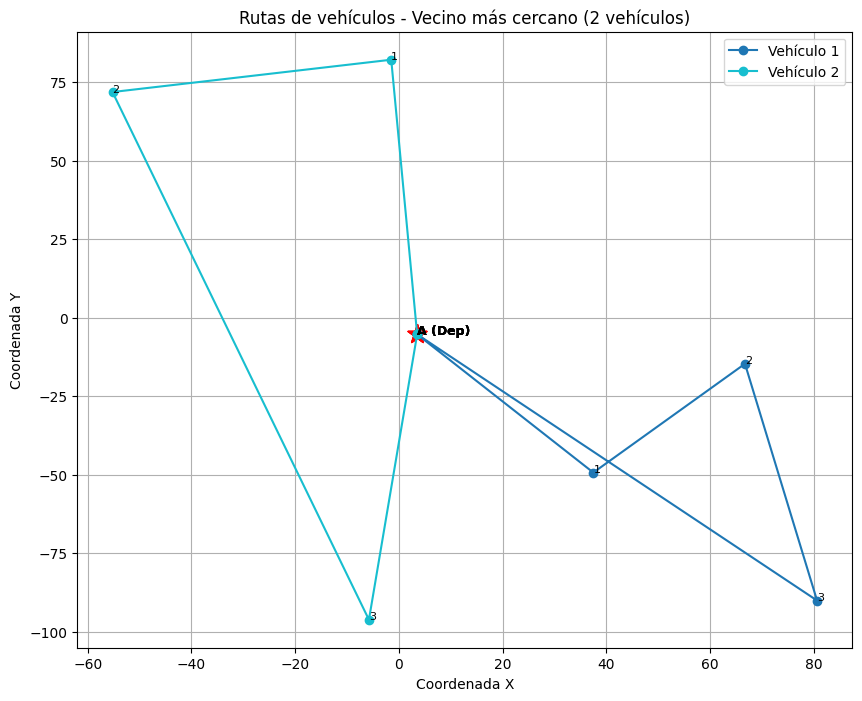

In [17]:

import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.figure(figsize=(10, 8))
colors = cm.get_cmap('tab10', len(rutas))

for i, ruta in enumerate(rutas):
    coords_x = [ciudades[ciudad][0] for ciudad in ruta]
    coords_y = [ciudades[ciudad][1] for ciudad in ruta]
    
    # Línea de la ruta
    plt.plot(coords_x, coords_y, marker='o', label=f"Vehículo {i+1}", color=colors(i))
    
    # Anotaciones
    for j, ciudad in enumerate(ruta):
        x, y = ciudades[ciudad]
        if j == 0 or j == len(ruta) - 1:
            plt.text(x, y, f"{ciudad} (Dep)", fontsize=9, weight='bold', color='black')
            plt.scatter(x, y, marker='*', color='red', s=200)
        else:
            plt.text(x, y, str(j), fontsize=8, color='black')

# Configuración general
plt.title("Rutas de vehículos - Vecino más cercano (2 vehículos)")
plt.xlabel("Coordenada X")
plt.ylabel("Coordenada Y")
plt.grid(True)
plt.legend()
plt.show()

In [18]:
def graficar_rutas_combinadas(rutas, ciudades, titulo="Rutas de vehículos"):

    plt.figure(figsize=(10, 8))
    colors = cm.get_cmap('tab10', len(rutas))

    for i, ruta in enumerate(rutas):
        coords_x = [ciudades[ciudad][0] for ciudad in ruta]
        coords_y = [ciudades[ciudad][1] for ciudad in ruta]

        # Dibujar ruta del vehículo
        plt.plot(coords_x, coords_y, marker='o', label=f"Vehículo {i+1}", color=colors(i))

        # Anotar orden de visita
        for j, ciudad in enumerate(ruta):
            x, y = ciudades[ciudad]
            if j == 0 or j == len(ruta) - 1:
                plt.text(x, y, f"{ciudad} (Dep)", fontsize=9, weight='bold', color='black')
                plt.scatter(x, y, marker='*', color='red', s=200)
            else:
                plt.text(x, y, str(j), fontsize=8, color='black')


    plt.title(titulo)
    plt.xlabel("Coordenada X")
    plt.ylabel("Coordenada Y")
    plt.grid(True)
    plt.legend()
    plt.show()

In [28]:
def graficar_rutas_comparadas(rutas_list, ciudades, titulos):

    fig, axs = plt.subplots(1, len(rutas_list), figsize=(18, 6))  # 3 gráficos lado a lado

    for idx, rutas in enumerate(rutas_list):
        ax = axs[idx]
        colors = cm.get_cmap('tab10', len(rutas))
        
        for i, ruta in enumerate(rutas):
            coords_x = [ciudades[ciudad][0] for ciudad in ruta]
            coords_y = [ciudades[ciudad][1] for ciudad in ruta]

            ax.plot(coords_x, coords_y, marker='o', label=f"Vehículo {i+1}", color=colors(i))

            for j, ciudad in enumerate(ruta):
                x, y = ciudades[ciudad]
                if j == 0 or j == len(ruta) - 1:
                    ax.text(x, y, f"{ciudad} (Dep)", fontsize=8, weight='bold', color='black')
                    ax.scatter(x, y, marker='*', color='red', s=150)
                else:
                    ax.text(x, y, str(j), fontsize=7, color='black')

        ax.set_title(titulos[idx])
        ax.set_xlabel("Coordenada X")
        ax.set_ylabel("Coordenada Y")
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

3 vehiculos

In [19]:
vehiculos_path = "./data/small-vrp/3.vehicles.csv"
df_vehiculos = pd.read_csv(vehiculos_path, sep=";")
df_vehiculos

,Vehicle_ID,Capacity
0,1,40
1,2,40
2,3,40


In [20]:
vehiculo_capacidades = df_vehiculos["Capacity"].tolist()
grupos_clientes = [[] for _ in range(len(vehiculo_capacidades))]
grupos_demanda = [0 for _ in range(len(vehiculo_capacidades))]

# Reusar los mismos clientes
clientes_sorted = clientes.sort_values(by="Demand", ascending=False)

for _, cliente in clientes_sorted.iterrows():
    for i in range(len(vehiculo_capacidades)):
        if grupos_demanda[i] + cliente["Demand"] <= vehiculo_capacidades[i]:
            grupos_clientes[i].append(cliente["Nombre"])
            grupos_demanda[i] += cliente["Demand"]
            break

In [22]:
from util_nearest_neighbor import nearest_neighbor

deposito = df_clientes[df_clientes["ID"] == 0]["Nombre"].values[0]

rutas_3v = []
for grupo in grupos_clientes:
    ruta = [deposito] + grupo + [deposito]
    sub_ciudades = {nombre: ciudades[nombre] for nombre in ruta}
    sub_distancias = {k: v for k, v in distancias.items() if k[0] in ruta and k[1] in ruta}
    ruta_ordenada = nearest_neighbor(sub_ciudades, sub_distancias)
    rutas_3v.append(ruta_ordenada)

C:\Users\aramirez\AppData\Local\Temp\ipykernel_29244\2386134909.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(rutas))


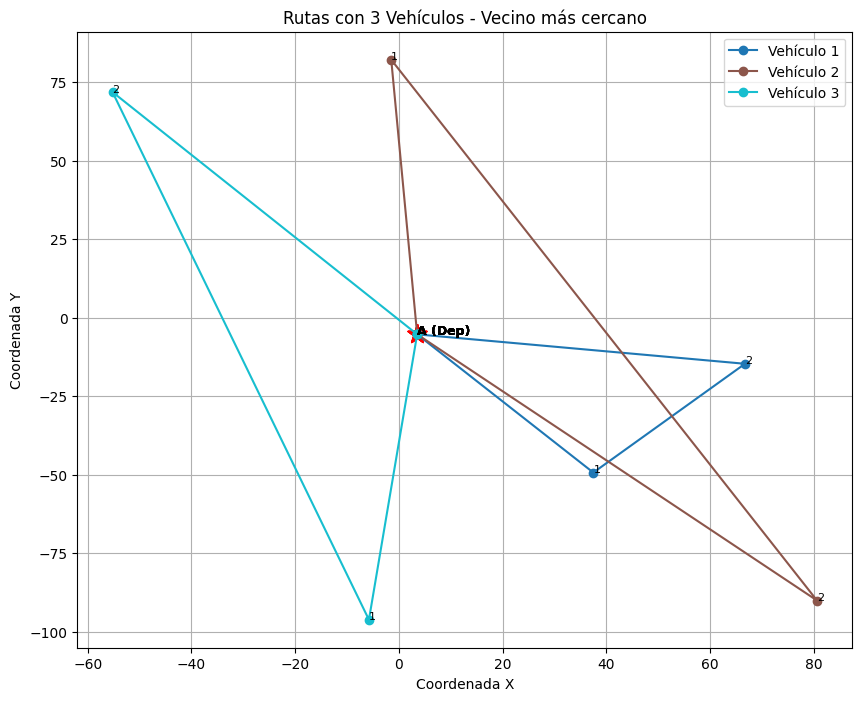

In [23]:
graficar_rutas_combinadas(rutas_3v, ciudades, titulo="Rutas con 3 Vehículos - Vecino más cercano")

4 vehiculos

In [24]:
vehiculos_path = "./data/small-vrp/4.vehicles.csv"
df_vehiculos = pd.read_csv(vehiculos_path, sep=";")
df_vehiculos

,Vehicle_ID,Capacity
0,1,40.0
1,2,20.0
2,3,10.0
3,4:50,NaN


In [25]:
vehiculo_capacidades = df_vehiculos["Capacity"].tolist()
grupos_clientes = [[] for _ in range(len(vehiculo_capacidades))]
grupos_demanda = [0 for _ in range(len(vehiculo_capacidades))]

# Ordenar clientes por demanda
clientes_sorted = clientes.sort_values(by="Demand", ascending=False)

for _, cliente in clientes_sorted.iterrows():
    for i in range(len(vehiculo_capacidades)):
        if grupos_demanda[i] + cliente["Demand"] <= vehiculo_capacidades[i]:
            grupos_clientes[i].append(cliente["Nombre"])
            grupos_demanda[i] += cliente["Demand"]
            break

In [26]:
rutas_4v = []
for grupo in grupos_clientes:
    ruta = [deposito] + grupo + [deposito]
    sub_ciudades = {nombre: ciudades[nombre] for nombre in ruta}
    sub_distancias = {k: v for k, v in distancias.items() if k[0] in ruta and k[1] in ruta}
    ruta_ordenada = nearest_neighbor(sub_ciudades, sub_distancias)
    rutas_4v.append(ruta_ordenada)

C:\Users\aramirez\AppData\Local\Temp\ipykernel_29244\2386134909.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(rutas))


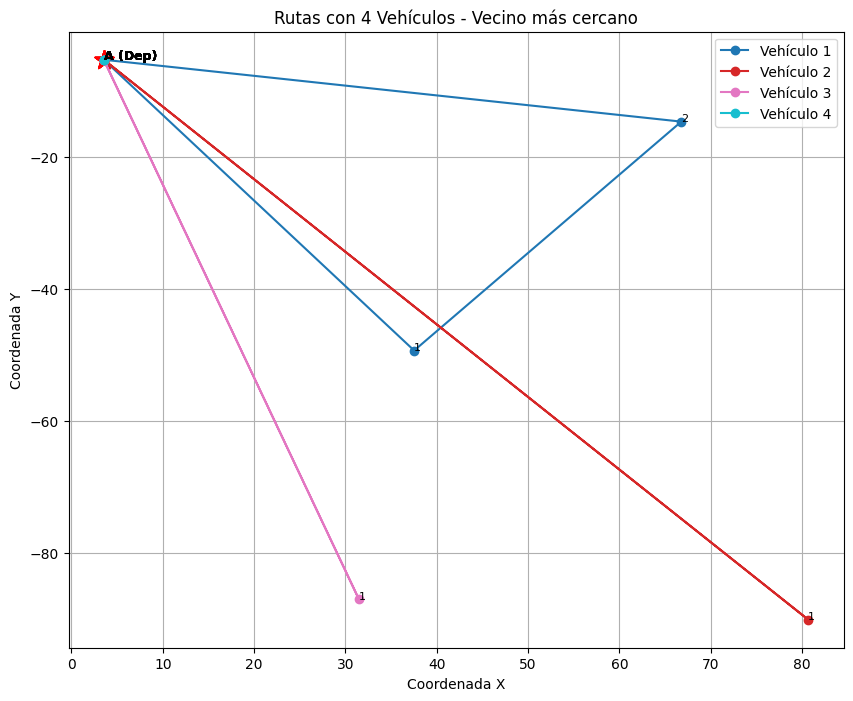

In [27]:
graficar_rutas_combinadas(rutas_4v, ciudades, titulo="Rutas con 4 Vehículos - Vecino más cercano")

C:\Users\aramirez\AppData\Local\Temp\ipykernel_29244\2045933623.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(rutas))


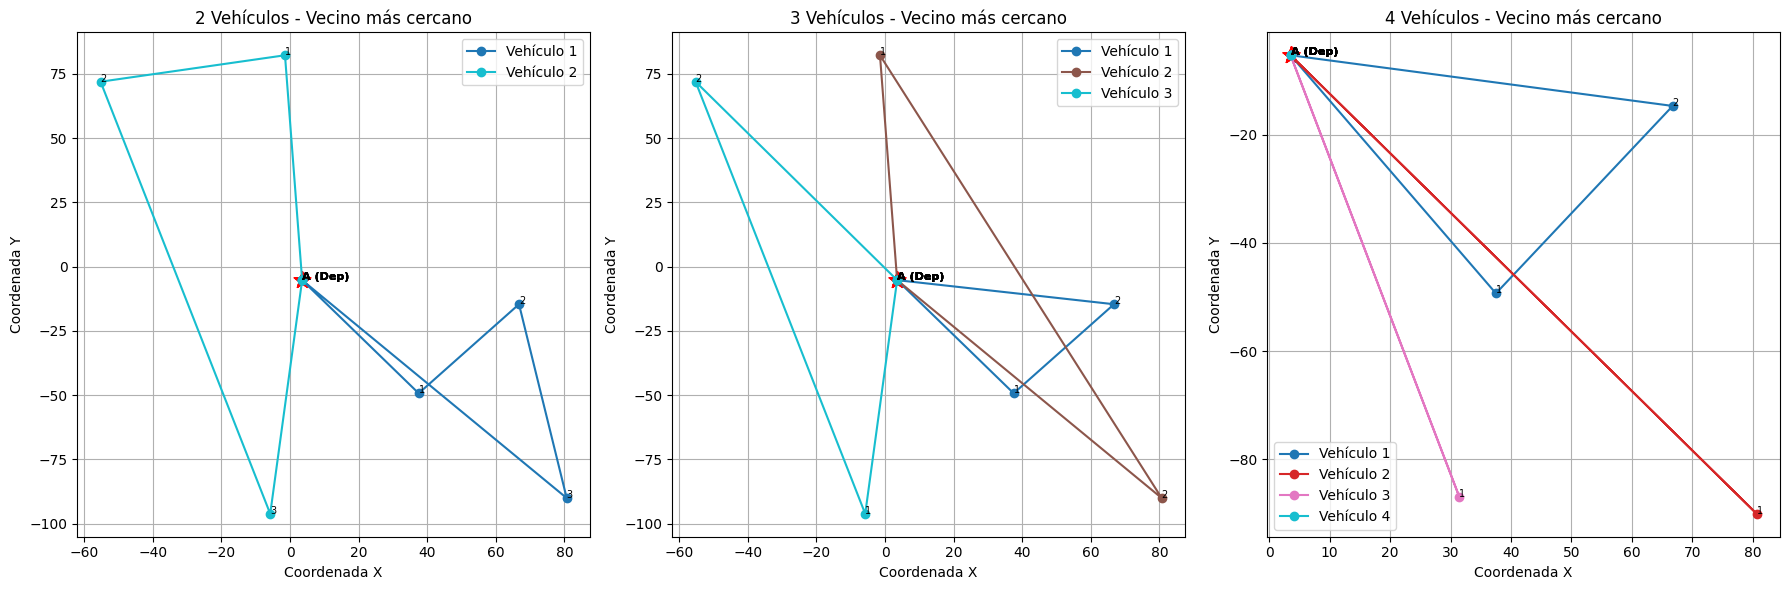

In [29]:
graficar_rutas_comparadas(
    rutas_list=[rutas, rutas_3v, rutas_4v],
    ciudades=ciudades,
    titulos=[
        "2 Vehículos - Vecino más cercano",
        "3 Vehículos - Vecino más cercano",
        "4 Vehículos - Vecino más cercano"
    ]
)